# Oxford Pets - Multiclass Classification

## Modules

In [1]:
import os
import sys

common_dir = os.path.abspath("../../common")
print(os.listdir(common_dir))

if common_dir not in sys.path:
    sys.path.append(common_dir)

['pt_trainer.py', 'tf_trainer.py', 'utils.py', '__pycache__']


In [2]:
import tensorflow as tf
from tensorflow import keras

import random
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, plot_progress
from tf_trainer import TrainerWithMetrics, TrainerWithEarlyStopping
from tf_trainer import accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

## Parameters

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
image_size = (224, 224)
batch_size = 32

In [5]:
save_weights = False
weights_name = "./tf_models/tf_oxford-pets_clf-37.h5"

## Data Set

In [6]:
from glob import glob
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def get_paths(image_dir, formats=["*"]):
    invalid_images = ['Egyptian_Mau_14',  'Egyptian_Mau_139', 'Egyptian_Mau_145',
                      'Egyptian_Mau_156', 'Egyptian_Mau_167', 'Egyptian_Mau_177',
                      'Egyptian_Mau_186', 'Egyptian_Mau_191', 'Abyssinian_5',
                      'Abyssinian_34',    'chihuahua_121',    'beagle_116']
    paths = []
    for ext in formats:
        paths += glob(os.path.join(image_dir, f"*.{ext}"))

    valid_paths = []
    for path in paths:
        image_name = os.path.basename(path).split('.')[0]
        if image_name not in invalid_images:
            valid_paths.append(path)
    return valid_paths


def get_labels(image_paths, n_classes=37):
    image_names = [os.path.basename(path).split('.')[0] for path in image_paths]
    if n_classes == 2:
        labels = ['cat' if name[0].isupper() else 'dog' for name in image_names]
    else:
        labels = [re.sub('_\d+', '', name) for name in image_names]
    return labels

def get_class_names(labels):
    return list(Counter(labels).keys())

def label_encoder(labels, class_names):
    encoder = {name: i for i, name in enumerate(class_names)}
    return [encoder[label] for label in labels]

In [7]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")

image_paths = get_paths(image_dir, formats=['jpg'])
labels = get_labels(image_paths, n_classes=37)
class_names = get_class_names(labels)
labels = label_encoder(labels, class_names)

print(f">> Images: {len(image_paths)}")
print(">> Class Names:", class_names)

>> Images: 7378
>> Class Names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [8]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, stratify=labels, train_size=0.8, random_state=seed)

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(
    train_image_paths, train_labels, stratify=train_labels, train_size=0.75, random_state=seed)

n_images = len(image_paths)
print(f">> Train images: {len(train_image_paths)} ({len(train_image_paths)/n_images:.2f})")
print(f">> Valid images: {len(valid_image_paths)} ({len(valid_image_paths)/n_images:.2f})")
print(f">> Test  images: {len(test_image_paths)} ({len(test_image_paths)/n_images:.2f})")

>> Train images: 4426 (0.60)
>> Valid images: 1476 (0.20)
>> Test  images: 1476 (0.20)


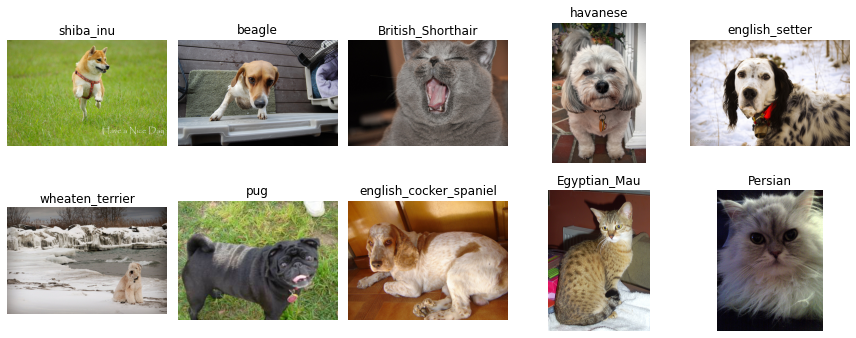

In [9]:
n_samples = 10
show_images(train_image_paths[:n_samples], labels=train_labels[:n_samples],
            class_names=class_names)

## Data Loader

In [10]:
import albumentations as A
from functools import partial

@tf.function
def load_data(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    return image, label

def augmenation(image, label, training):
    transform = train_transform if training else valid_transform
    transformed = transform(image=image)
    image = transformed['image']

    # image = tf.cast(image, dtype=tf.float32)/255
    image = tf.cast(image, dtype=tf.float32)
    label = tf.cast(label, dtype=tf.int64)
    return image, label

@tf.function
def preprocess(image, label, training):
    image, label = tf.numpy_function(augmenation,
                        inp=[image, label, training],
                        Tout=[tf.float32, tf.int64])
    return image, label

def get_dataloader(image_paths, labels, batch_size, training, shuffle=True):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataloader = tf.data.Dataset.from_tensor_slices((image_paths, labels)).cache()
    dataloader = dataloader.map(load_data, num_parallel_calls=AUTOTUNE)
    dataloader = dataloader.map(partial(preprocess, training=training),
                                num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataloader = dataloader.shuffle(1000)
    dataloader = dataloader.batch(batch_size).prefetch(AUTOTUNE)
    return dataloader

train_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.05, 
                       rotate_limit=15,),
    A.CoarseDropout(p=0.5, max_holes=8, max_height=int(0.1*image_size[0]), 
                    max_width=int(0.1*image_size[1])),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

valid_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

train_loader = get_dataloader(train_image_paths, train_labels, 
                              batch_size, training=True, shuffle=True)
valid_loader = get_dataloader(valid_image_paths, valid_labels, 
                              batch_size, training=False, shuffle=False)
test_loader = get_dataloader(test_image_paths, test_labels, 
                             batch_size, training=False, shuffle=False)

<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 224, 224, 3) <dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'> (32,) <dtype: 'int64'>
>> Images: min: 0, max: 255
>> Labels: min: 2, max: 36


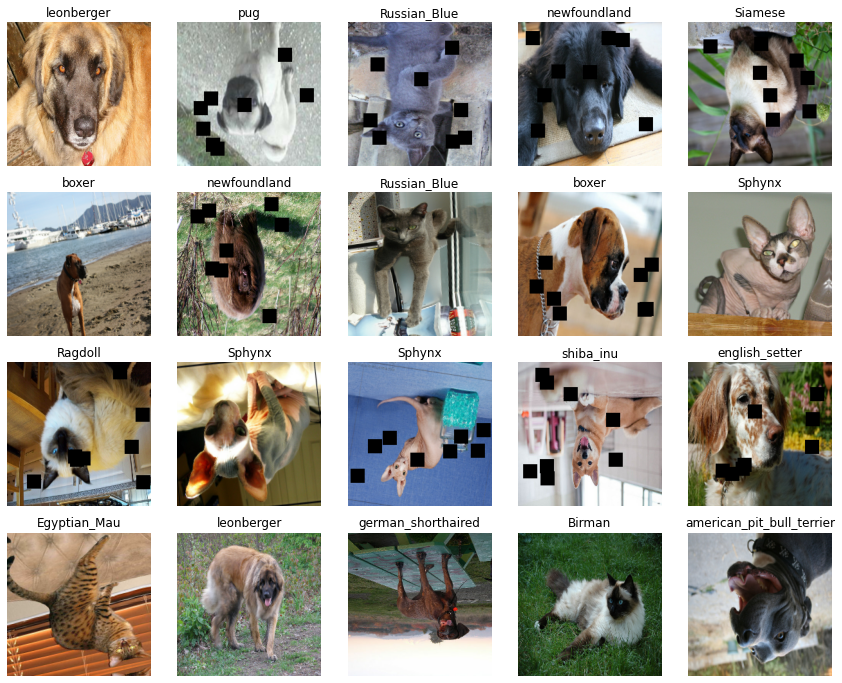

In [11]:
images, labels = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(labels), labels.shape, labels.dtype)

images = images.numpy().astype(int)
labels = labels.numpy()

n_samples = 20
print(f">> Images: min: {images.min()}, max: {images.max()}")
print(f">> Labels: min: {labels.min()}, max: {labels.max()}")
show_images(images[:n_samples], labels=labels[:n_samples], 
            class_names=class_names, denormalize=False)

### Modeling

 * https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v3/weights_mobilenet_v3_large_224_1.0_float_no_top_v2.h5

In [12]:
from  tensorflow.keras.applications import mobilenet_v3, MobileNetV3Large
from  tensorflow.keras.applications import efficientnet_v2, EfficientNetV2S
from  tensorflow.keras.applications import densenet, DenseNET201

pretrained_models = {'mobilenetv3': MobileNetV3Large,
                     'densenet': DenseNET201,
                     'efficientnetv2': efficientnet_v2.EfficientNetV2S}
preprocess_inputs = {'mobilenetv3': mobilenet_v3.preprocess_input,
                     'densenet': densenet.preprocess_input,
                     'efficientnetv2': efficientnet_v2.preprocess_input}

def get_pretrained_model(model_name, input_shape, n_classes, freezed=True):
    base_model = pretrained_models[model_name](input_shape=input_shape,
                             weights='imagenet', include_top=False)
    base_model.trainable = not freezed

    inputs = keras.Input(shape=input_shape)
    x = preprocess_inputs[model_name](inputs)
    x = base_model(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.ReLU()(x)
    outputs = keras.layers.Dense(n_classes)(x)
    return keras.Model(inputs, outputs)

## Training

In [13]:
%%time
## Feature Extraction

model = get_pretrained_model('efficientnetv2', input_shape=(224, 224, 3), n_classes=37, freezed=True)
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics={'acc': accuracy})
hist = clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" 
                       for key, value in results.items()]))

Epoch[  1/100] loss=1.1987, acc=0.6946 | val_loss=0.3387, val_acc=0.8976 (1)                        
Epoch[  2/100] loss=0.6289, acc=0.8104 | val_loss=0.2678, val_acc=0.9209 (1)                        
Epoch[  3/100] loss=0.5393, acc=0.8232 | val_loss=0.2556, val_acc=0.9249 (1)                        
Epoch[  4/100] loss=0.4838, acc=0.8491 | val_loss=0.2363, val_acc=0.9302 (1)                        
Epoch[  5/100] loss=0.4654, acc=0.8480 | val_loss=0.2400, val_acc=0.9242 (2)                        
Epoch[  6/100] loss=0.4105, acc=0.8711 | val_loss=0.2558, val_acc=0.9109 (3)                        
Epoch[  7/100] loss=0.3750, acc=0.8781 | val_loss=0.2126, val_acc=0.9315 (1)                        
Epoch[  8/100] loss=0.3839, acc=0.8736 | val_loss=0.2088, val_acc=0.9328 (1)                        
Epoch[  9/100] loss=0.3761, acc=0.8703 | val_loss=0.2279, val_acc=0.9242 (2)                        
Epoch[ 10/100] loss=0.3512, acc=0.8835 | val_loss=0.2300, val_acc=0.9302 (3)               

In [14]:
%%time
## Fine Tuneing

model.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics={'acc': accuracy})
hist = clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" 
                       for key, value in results.items()]))

Epoch[  1/100] loss=1.3863, acc=0.5973 | val_loss=0.4525, val_acc=0.8577 (1)                        
Epoch[  2/100] loss=1.0247, acc=0.6911 | val_loss=0.3623, val_acc=0.8803 (1)                        
Epoch[  3/100] loss=0.7799, acc=0.7692 | val_loss=0.3151, val_acc=0.8956 (1)                        
Epoch[  4/100] loss=0.6465, acc=0.7968 | val_loss=0.2895, val_acc=0.9082 (1)                        
Epoch[  5/100] loss=0.5578, acc=0.8287 | val_loss=0.2677, val_acc=0.9082 (1)                        
Epoch[  6/100] loss=0.4986, acc=0.8498 | val_loss=0.2578, val_acc=0.9122 (1)                        
Epoch[  7/100] loss=0.4182, acc=0.8721 | val_loss=0.2476, val_acc=0.9176 (1)                        
Epoch[  8/100] loss=0.4086, acc=0.8764 | val_loss=0.2400, val_acc=0.9229 (1)                        
Epoch[  9/100] loss=0.3446, acc=0.8922 | val_loss=0.2344, val_acc=0.9229 (1)                        
Epoch[ 10/100] loss=0.3320, acc=0.8953 | val_loss=0.2295, val_acc=0.9195 (1)               

In [15]:
clf = TrainerWithMetrics(model, optimizer, loss_fn, metrics={'acc': accuracy})
hist = clf.fit(valid_loader, n_epochs=3)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" 
                       for key, value in results.items()]))

Epoch[  1/  3] loss=0.3224, acc=0.9082                                                              
Epoch[  2/  3] loss=0.1405, acc=0.9588                                                              
Epoch[  3/  3] loss=0.0747, acc=0.9820                                                              
>> test_loss=0.2122, test_acc=0.9362                                                                


In [16]:
if save_weights:
    model.save_weights(weights_name)

## Inference

In [17]:
if save_weights:
    model = get_pretrained_model('mobilenetv2', input_shape=(224, 224, 3), n_classes=37, freezed=True)
    model.load_weights(weights_name)

>> Ground Truth:


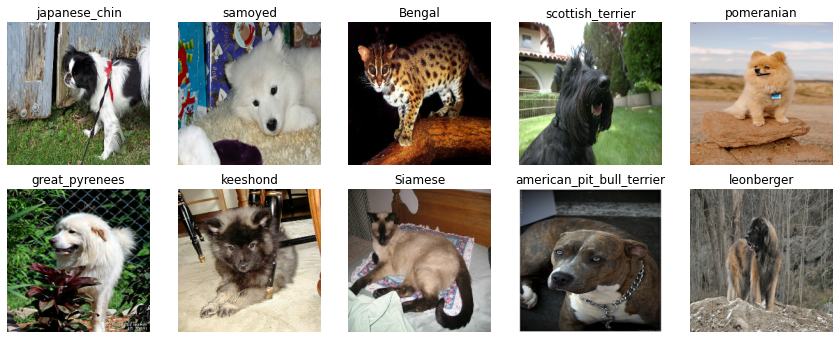

>> Predictions:


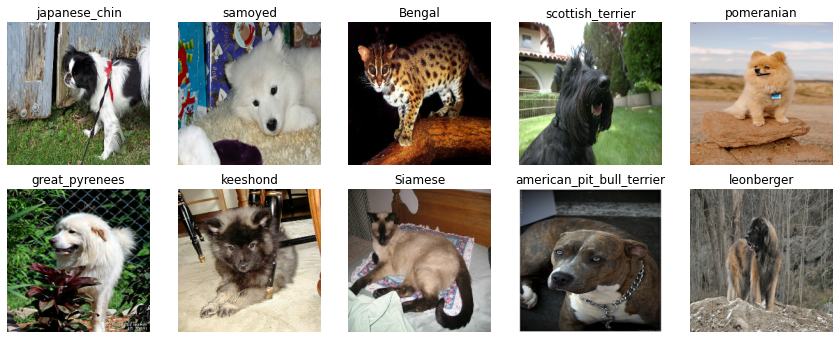

In [18]:
images, labels = next(iter(test_loader))
preds = model.predict(images, verbose=0)

images = images.numpy().astype(int)
labels = labels.numpy()
preds = softmax(preds).argmax(axis=-1)

n_samples = 10
print(f">> Ground Truth:")
show_images(images[:n_samples], labels=labels[:n_samples], class_names=class_names)

print(f">> Predictions:")
show_images(images[:n_samples], labels=preds[:n_samples], class_names=class_names)